In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary scikit-learn modules and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, auc, accuracy_score, precision_score, recall_score,
                             matthews_corrcoef, f1_score, average_precision_score,
                             cohen_kappa_score, log_loss)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset into a Pandas DataFrame
credit_card_data = pd.read_csv('Downloads/creditcard_2023.csv')

In [3]:
# Assuming 'Class' is the target and the rest are features
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

In [4]:
# Split the data into training and testing sets with stratification (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [5]:
# Initialize the Gaussian Naive Bayes model
model = GaussianNB()

In [6]:
# Start timer to measure training time
start_time = time.time()

# Fit the model on the training data
model.fit(X_train, Y_train)

# End timer and record elapsed time
end_time = time.time()
training_time = end_time - start_time
print(f"Time taken to fit the model: {training_time:.2f} seconds")

Time taken to fit the model: 0.22 seconds


In [7]:
# Evaluate on training data
Y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(Y_train, Y_train_pred)
print('Training Accuracy:', training_accuracy)

Training Accuracy: 0.9944911453845207


In [8]:
# Evaluate on test data
Y_pred = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_pred)
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.9945219211086295


In [9]:
# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56863
           1       1.00      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



In [10]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[56863     0]
 [  623 56240]]


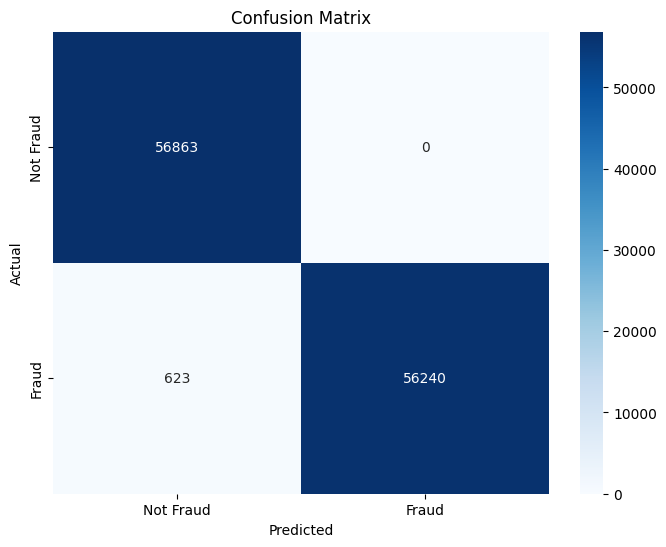

In [11]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Extract individual values from the confusion matrix: TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

In [13]:
# Calculate basic derived metrics
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Recall: ability to detect fraud
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Ability to correctly identify legitimate transactions
precision = TP / (TP + FP) if (TP + FP) != 0 else 0      # Proportion of predicted frauds that are actual frauds
mcc = matthews_corrcoef(Y_test, Y_pred)                  # Matthews Correlation Coefficient
BCR = (sensitivity + specificity) / 2                    # Balanced Classification Rate

In [14]:
# Calculate additional metrics
f1 = f1_score(Y_test, Y_pred)                            # F1 Score: harmonic mean of precision and recall
# Use predict_proba since GaussianNB supports it
avg_precision = average_precision_score(Y_test, model.predict_proba(X_test)[:, 1])  # Average Precision (AUC-PR)
kappa = cohen_kappa_score(Y_test, Y_pred)                # Cohen's Kappa: agreement adjusted for chance
logloss = log_loss(Y_test, model.predict_proba(X_test))  # Log Loss: measure of probability calibration

In [15]:
print("\nDerived Metrics:")
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("F1 Score:", f1)
print("MCC:", mcc)
print("BCR:", BCR)
print("Average Precision (AUC-PR):", avg_precision)
print("Cohen's Kappa:", kappa)
print("Log Loss:", logloss)


Derived Metrics:
Sensitivity (Recall): 0.989043842217259
Specificity: 1.0
Precision: 1.0
F1 Score: 0.9944917464611902
MCC: 0.989103208684329
BCR: 0.9945219211086296
Average Precision (AUC-PR): 0.9994558524388202
Cohen's Kappa: 0.989043842217259
Log Loss: 0.057247656179957744


In [16]:
# Get probability estimates for the positive class for ROC computation
Y_pred_proba = model.predict_proba(X_test)[:, 1]

In [17]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9991


In [18]:
# Compute ROC curve data points
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc_val = auc(fpr, tpr)

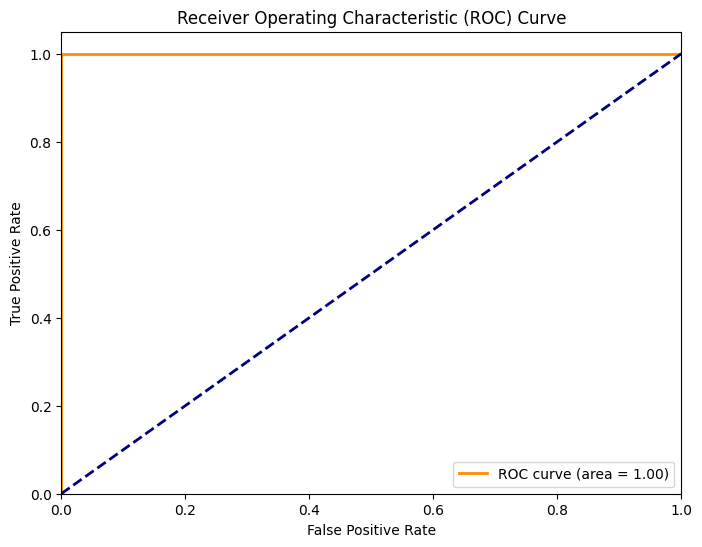

In [19]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Use the ROC curve for practical threshold selection:
# Calculate Youden's J statistic (tpr - fpr) and choose the threshold with maximum J.
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold (Youden's Index):", optimal_threshold)

Optimal Threshold (Youden's Index): 0.37122118518431607


In [21]:
# Recalculate predictions using the optimal threshold
Y_pred_optimal = (Y_pred_proba >= optimal_threshold).astype(int)
opt_conf_matrix = confusion_matrix(Y_test, Y_pred_optimal)
opt_accuracy = accuracy_score(Y_test, Y_pred_optimal)
print("\nMetrics with Optimal Threshold:")
print("Optimal Test Accuracy:", opt_accuracy)
print("Optimal Confusion Matrix:")
print(opt_conf_matrix)


Metrics with Optimal Threshold:
Optimal Test Accuracy: 0.9989360392522378
Optimal Confusion Matrix:
[[56854     9]
 [  112 56751]]


In [22]:
# GaussianNB does not provide feature importances
print("\nFeature Importance:")
print("GaussianNB does not provide feature importances.")


Feature Importance:
GaussianNB does not provide feature importances.


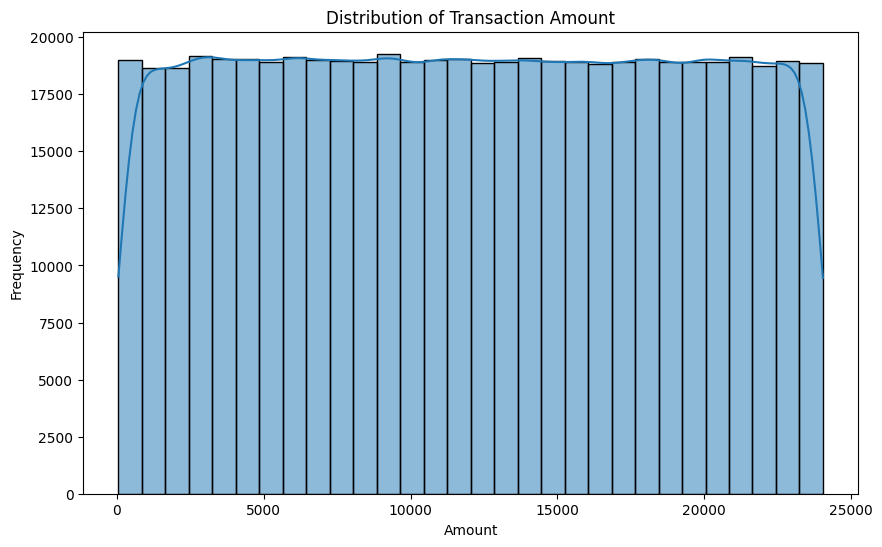

In [23]:
# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['Amount'], kde=True, bins=30)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

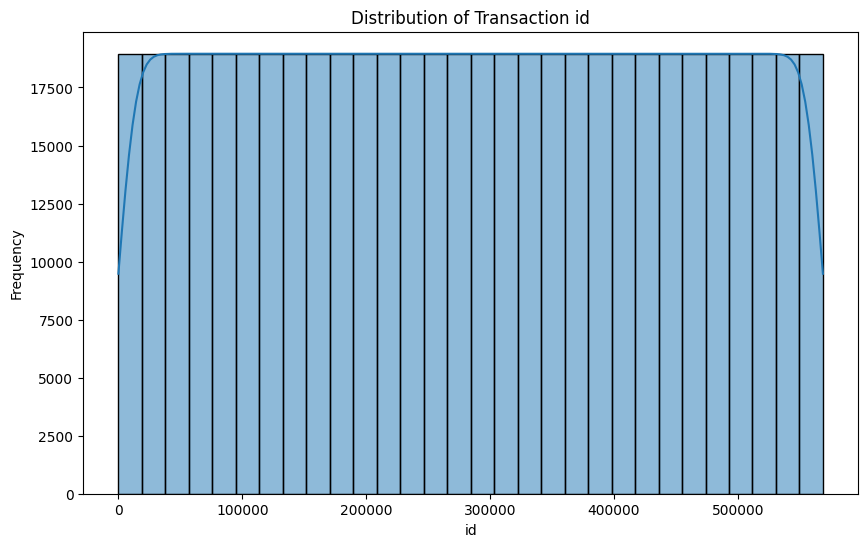

In [24]:
# Distribution of Transaction ID (handle infinite values)
credit_card_data['id'] = credit_card_data['id'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['id'], kde=True, bins=30)
plt.title('Distribution of Transaction id')
plt.xlabel('id')
plt.ylabel('Frequency')
plt.show()

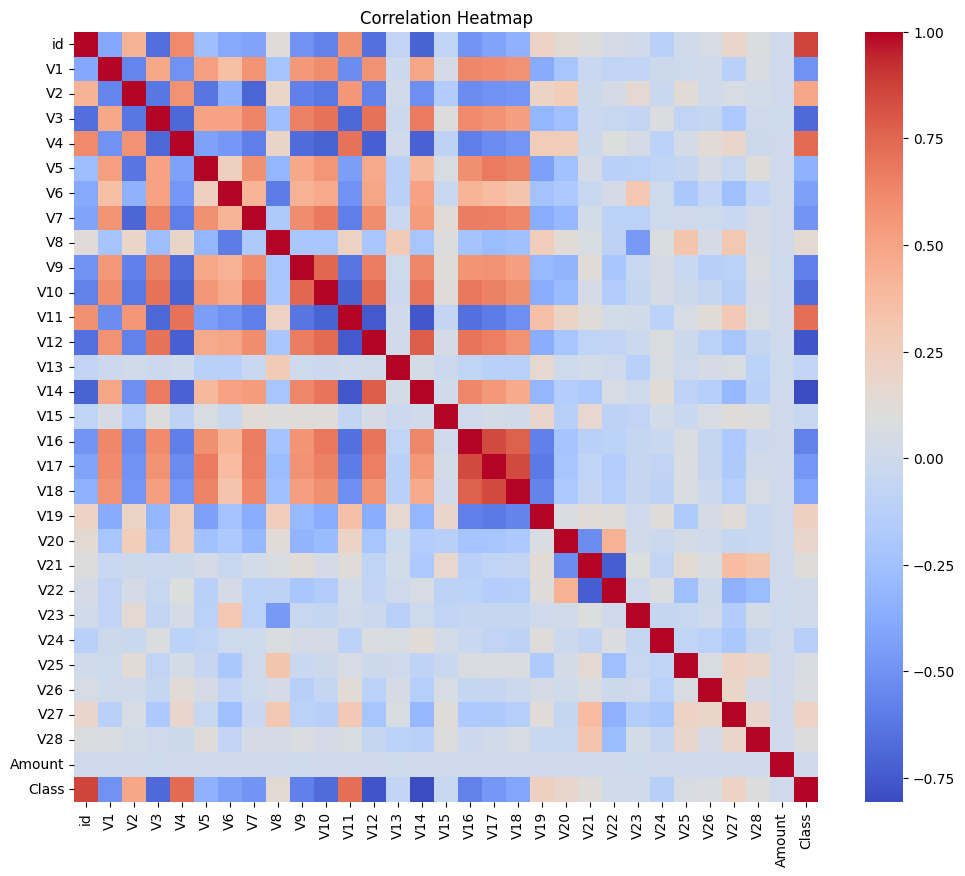

In [25]:
# Correlation Heatmap for the entire dataset
plt.figure(figsize=(12, 10))
corr = credit_card_data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [26]:
# Create a dictionary to store evaluation metrics for this model.
results = {}
results["GaussianNB"] = {
    "Training Accuracy": training_accuracy,
    "Test Accuracy": test_accuracy,
    "Optimal Test Accuracy": opt_accuracy,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1 Score": f1,
    "MCC": mcc,
    "BCR": BCR,
    "ROC AUC": roc_auc,
    "Average Precision": avg_precision,
    "Cohen's Kappa": kappa,
    "Log Loss": logloss,
    "Training Time (s)": training_time,
    "Optimal Threshold": optimal_threshold
}

In [27]:
# If you have multiple models, repeat the above block for each and add entries accordingly.
results_df = pd.DataFrame(results).T  # Transpose so each row represents a model
print("\nComparison Table of Evaluation Metrics:")
print(results_df)


Comparison Table of Evaluation Metrics:
            Training Accuracy  Test Accuracy  Optimal Test Accuracy  \
GaussianNB           0.994491       0.994522               0.998936   

            Sensitivity  Specificity  Precision  F1 Score       MCC       BCR  \
GaussianNB     0.989044          1.0        1.0  0.994492  0.989103  0.994522   

             ROC AUC  Average Precision  Cohen's Kappa  Log Loss  \
GaussianNB  0.999107           0.999456       0.989044  0.057248   

            Training Time (s)  Optimal Threshold  
GaussianNB            0.22319           0.371221  
